In [1]:
# open /home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/pc.npy
import numpy as np
pc = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/pc.npy')

In [2]:
pc.shape

(3, 481, 607)

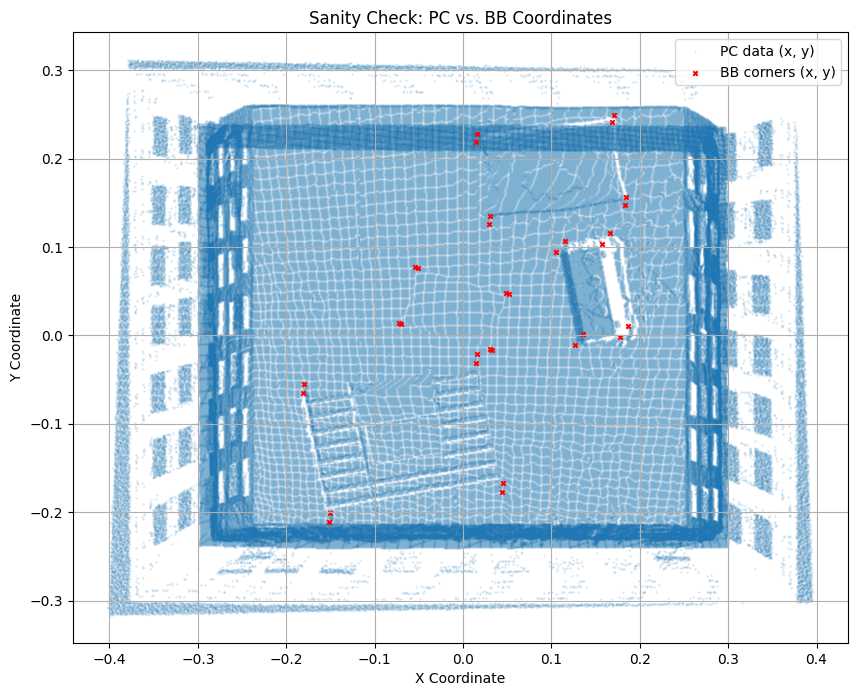

PC Data X Range: -0.4014720389008415 0.3956448222312365
PC Data Y Range: -0.31636215090283726 0.31159209631825086
BB X Range: -0.18094139 0.18701322
BB Y Range: -0.21139666 0.24972415


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Load the data ---
pc_data = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/pc.npy')
bb_corners_3d = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/bbox3d.npy')

# Get coordinates from pc data
pc_x = pc_data[0, :, :].flatten()
pc_y = pc_data[1, :, :].flatten()

# Get coordinates from all bounding box corners
bb_x = bb_corners_3d[:, :, 0].flatten()
bb_y = bb_corners_3d[:, :, 1].flatten()

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(pc_x, pc_y, s=1, label='PC data (x, y)', alpha=0.1)
plt.scatter(bb_x, bb_y, s=10, c='red', marker='x', label='BB corners (x, y)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Sanity Check: PC vs. BB Coordinates')
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

# Print the coordinate ranges
print("PC Data X Range:", np.min(pc_x), np.max(pc_x))
print("PC Data Y Range:", np.min(pc_y), np.max(pc_y))
print("BB X Range:", np.min(bb_x), np.max(bb_x))
print("BB Y Range:", np.min(bb_y), np.max(bb_y))

In [2]:
import numpy as np
import cv2
import matplotlib.cm as cm

# --- 1. Load all data ---
pc_data = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/pc.npy')
bb_corners_3d = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/bbox3d.npy')
masks_data = np.load('/home/as2114/code/3DBB/data/dl_challenge/8b061a8a-9915-11ee-9103-bbb8eae05561/mask.npy')

# Get dimensions
_, h, w = pc_data.shape

# --- USER PARAMETERS TO TWEAK ---
FLIP_X = False
FLIP_Y = True  # Often necessary for image coordinates
SWAP_XY = False
# --- END USER PARAMETERS ---

# Get coordinates from pc data
pc_x = pc_data[0, :, :]
pc_y = pc_data[1, :, :]
pc_z = pc_data[2, :, :]

if SWAP_XY:
    pc_x, pc_y = pc_y, pc_x
if FLIP_X:
    pc_x = -pc_x
if FLIP_Y:
    pc_y = -pc_y

# --- Create a BEV image (Height Map) ---
z_min, z_max = np.min(pc_z), np.max(pc_z)
height_map = (pc_z - z_min) / (z_max - z_min) * 255.0
bev_image = cv2.cvtColor(height_map.astype(np.uint8), cv2.COLOR_GRAY2BGR)

# --- Create mask visualization ---
colored_masks = np.zeros_like(bev_image)
alpha = 0.5
num_masks = masks_data.shape[0]
cmap = cm.get_cmap('gist_rainbow', num_masks)
for i in range(num_masks):
    mask = masks_data[i, :, :]
    color = cmap(i)[:3]
    color_bgr = tuple(int(c * 255) for c in color[::-1])
    for c_ in range(3):
        colored_masks[:, :, c_] = np.where(mask > 0.5, color_bgr[c_], colored_masks[:, :, c_])
output_image = cv2.addWeighted(bev_image, 1 - alpha, colored_masks, alpha, 0)

# --- Project and Draw Bounding Boxes ---
# Apply the same transformations to the BB data
bb_x, bb_y, bb_z = bb_corners_3d[:, :, 0], bb_corners_3d[:, :, 1], bb_corners_3d[:, :, 2]
if SWAP_XY:
    bb_x, bb_y = bb_y, bb_x
if FLIP_X:
    bb_x = -bb_x
if FLIP_Y:
    bb_y = -bb_y

x_min_range, x_max_range = np.min(pc_x), np.max(pc_x)
y_min_range, y_max_range = np.min(pc_y), np.max(pc_y)
x_scale = w / (x_max_range - x_min_range)
y_scale = h / (y_max_range - y_min_range)

def project_3d_to_bev(x, y, z):
    u = (x - x_min_range) * x_scale
    v = (y - y_min_range) * y_scale
    v = h - 1 - v
    return int(u), int(v)

bottom_face_indices = np.array([0, 1, 2, 3])

for i in range(bb_corners_3d.shape[0]):
    corners_3d = bb_corners_3d[i]
    bottom_corners_3d = corners_3d[bottom_face_indices, :]
    
    # Project based on the final, transformed coordinates
    corners_2d_proj = [project_3d_to_bev(c[0], c[1], c[2]) for c in bottom_corners_3d]
    
    valid_coords = [c for c in corners_2d_proj if 0 <= c[0] < w and 0 <= c[1] < h]
    if len(valid_coords) < 4:
        continue

    corners_2d_proj = np.array(corners_2d_proj)
    edges = [(0, 1), (1, 2), (2, 3), (3, 0)]

    for start, end in edges:
        p1 = tuple(corners_2d_proj[start])
        p2 = tuple(corners_2d_proj[end])
        cv2.line(output_image, p1, p2, (0, 255, 0), 2)

output_path = 'complete_bev_visualization.png'
cv2.imwrite(output_path, output_image)
print(f"Complete visualization saved to {output_path}")

Complete visualization saved to complete_bev_visualization.png


/tmp/ipykernel_3299021/2471489034.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('gist_rainbow', num_masks)
